## 2nd iteration of my own sheet

Creating my own version of the dogs_cats_redux notebook in order to make my own entry into the Kaggle competition.

See 1st sheet for setup info

In [2]:
%matplotlib inline
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))
from utils import *
#from vgg16 import Vgg16
#from vgg16bn import Vgg16BN
from PIL import Image
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import pandas as pd

Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/home/rallen/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [3]:
#Verify we are in the lesson1 directory
#%pwd
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

## Create validation set and sample
## Rearrange image files into their respective directories

did these in previous notebook, no longer

## Finetuning and Training

OKAY, ITERATE HERE

In [36]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' 
#path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/rallen/Documents/Devel/PracticalDL4C/kaggle/dogscats/data


In [37]:
vgg = Vgg16BN()

/home/rallen/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [38]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=30

In [39]:
# NEW! Augment the data
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [40]:
#Finetune the model
# NEW, just add gen as 2nd parameter to batches
batches = vgg.get_batches(train_path, gen, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [41]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

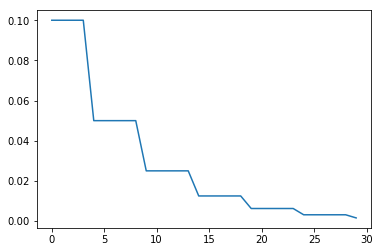

In [42]:
INIT_LR=0.1
EPOCHS_DROP=5.0
DROP=0.5

def step_decay(epoch, initial_lrate = INIT_LR, epochs_drop = EPOCHS_DROP, drop = DROP):
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# just for plotting
def np_step_decay(epoch, initial_lrate = INIT_LR, epochs_drop = EPOCHS_DROP, drop = DROP):
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

X = np.arange(30)
Y = np_step_decay(X)#,0.01,3)
plt.plot(X,Y)

In [43]:
#vgg.model.optimizer.lr = 0.0001

#latest_weights_filename="weights-02-04-1.00.hdf5"
#vgg.model.load_weights(results_path+latest_weights_filename)

run_index=20 # restarting fresh
#run_index+=1
filepath=results_path+"run-%02d-weights-{epoch:02d}-{val_acc:.2f}.hdf5"%(run_index)
history_filepath=results_path+"run-%02d-history.csv"%(run_index)

checkpoint = ModelCheckpoint(filepath, 
                             #monitor='val_acc', mode='max',
                             monitor='val_loss', mode='min',
                             verbose=1, 
                             save_weights_only=True, save_best_only=True)
lr_scheduler = LearningRateScheduler(step_decay)
callbacks = [checkpoint,lr_scheduler]

In [44]:
history = vgg.fit(batches, val_batches, no_of_epochs, callbacks)

Epoch 1/30
23000/23000 [==============================] - 379s - loss: 0.9919 - acc: 0.9361 - val_loss: 0.4788 - val_acc: 0.9670
Epoch 2/30
23000/23000 [==============================] - 256s - loss: 0.9215 - acc: 0.9421 - val_loss: 0.4838 - val_acc: 0.9700
Epoch 3/30
23000/23000 [==============================] - 255s - loss: 1.0124 - acc: 0.9367 - val_loss: 0.5400 - val_acc: 0.9665
Epoch 4/30
23000/23000 [==============================] - 260s - loss: 0.9333 - acc: 0.9416 - val_loss: 0.5017 - val_acc: 0.9685
Epoch 5/30
23000/23000 [==============================] - 261s - loss: 0.8190 - acc: 0.9487 - val_loss: 0.4701 - val_acc: 0.9705
Epoch 6/30
23000/23000 [==============================] - 261s - loss: 0.7785 - acc: 0.9513 - val_loss: 0.3935 - val_acc: 0.9750
Epoch 7/30
23000/23000 [==============================] - 260s - loss: 0.7627 - acc: 0.9525 - val_loss: 0.3949 - val_acc: 0.9755
Epoch 8/30
23000/23000 [==============================] - 261s - loss: 0.6990 - acc: 0.9563 - val

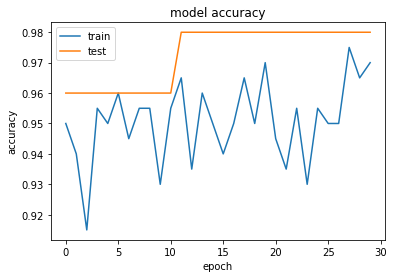

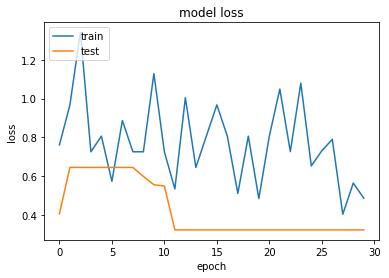

In [19]:
#print(history.history.keys())
# summarize history for accuracy
def plot_history(h):
    plt.plot(h['acc'])
    plt.plot(h['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history.history)

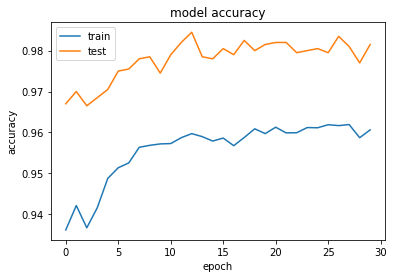

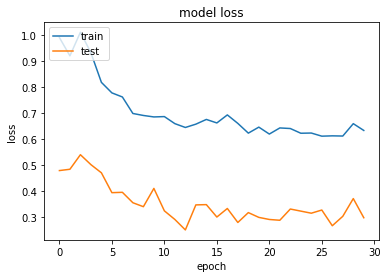

In [45]:
history_df = pd.DataFrame(history.history)
#history_df.to_csv(history_filepath)
plot_history(history_df)

In [46]:
def underfit(train_err, test_error):
    return train_err < test_error * 0.667

def overfit(train_acc, test_acc):
    return train_acc > test_acc

history_df["underfit"] = map(underfit, history_df["loss"], history_df["val_loss"])
history_df["overfit"] = map(overfit, history_df["acc"], history_df["val_acc"])

In [47]:
history_df

,acc,loss,val_acc,val_loss,underfit,overfit
0,0.936130,0.991865,0.9670,0.478799,False,False
1,0.942087,0.921492,0.9700,0.483812,False,False
2,0.936652,1.012415,0.9665,0.539956,False,False
3,0.941565,0.933349,0.9685,0.501681,False,False
4,0.948739,0.819042,0.9705,0.470146,False,False
5,0.951348,0.778473,0.9750,0.393532,False,False
6,0.952522,0.762656,0.9755,0.394893,False,False
7,0.956348,0.699003,0.9780,0.354652,False,False
8,0.956826,0.691358,0.9785,0.339424,False,False
9,0.957174,0.685687,0.9745,0.409944,False,False


if you are training, stay here.  if you are loading & creating submission skip down from here.

In [ ]:
## if you have run some epochs already...
## let's try reducing this & give it another go
##vgg.model.optimizer.lr = 0.001
#epoch_offset=0
#for epoch in range(no_of_epochs):
#    print "Running epoch: %d" % (epoch + epoch_offset)
#    vgg.fit(batches, val_batches, nb_epoch=1)
#    latest_weights_filename = 'nbgt%d.h5' % (epoch + epoch_offset)
#    vgg.model.save_weights(results_path+latest_weights_filename)
#print "Completed %s fit operations" % no_of_epochs

```
Results of ft1.h5
0 val_loss: 0.2122 val_acc: 0.9830
1 val_loss: 0.1841 val_acc: 0.9855
[[987   7]
 [ 20 986]]
--
2 val_loss: 0.2659 val_acc: 0.9830
3 val_loss: 0.2254 val_acc: 0.9850
4 val_loss: 0.2072 val_acc: 0.9845
[[975  19]
 [ 11 995]]
 
Results of first0.h5
0 val_loss: 0.2425 val_acc: 0.9830
[[987   7]
 [ 27 979]]
 
ft35 with augmented images
0 val_loss: 0.3139 - val_acc: 0.9805
[[ 959   35]
 [   4 1002]]
+ 0.001 lr
0 val_loss: 0.2530 - val_acc: 0.9830
[[ 966   28]
 [   6 1000]]
+2 iters
0 val_loss: 0.2221 - val_acc: 0.9860
1 val_loss: 0.2626 - val_acc: 0.9830
[[973  21]
 [  8 998]]

```

In [ ]:
# only if you have to
latest_weights_filename='ft1.h5'
vgg.model.load_weights(results_path+latest_weights_filename)

## Validate Predictions

In [48]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

Found 2000 images belonging to 2 classes.


[[964  30]
 [  8 998]]


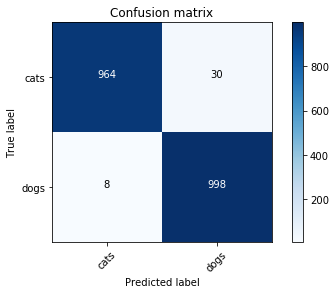

In [49]:
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [27]:
#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 50 correct labels


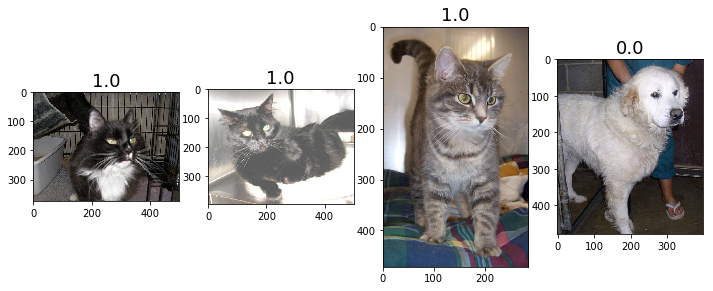

In [52]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 38 incorrect labels


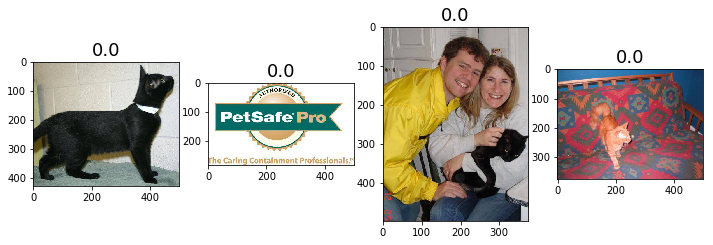

In [54]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 28 confident correct cats labels


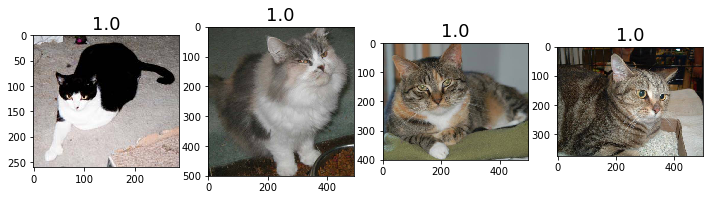

In [29]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 21 confident correct dogs labels


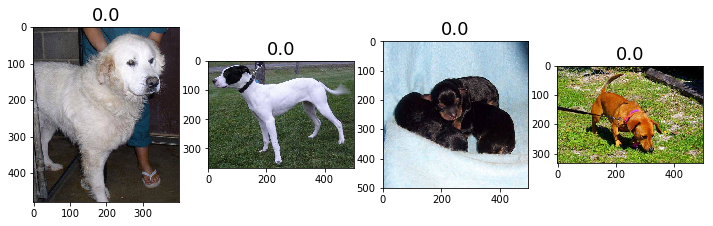

In [30]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 1 incorrect cats


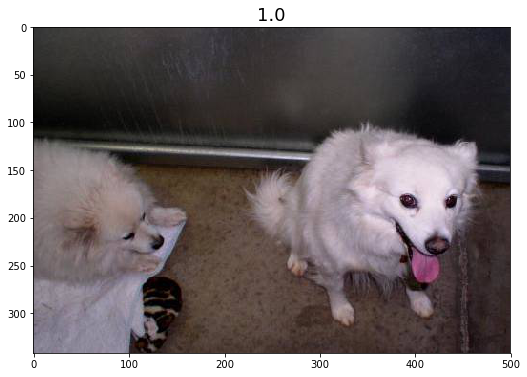

In [31]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

In [ ]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

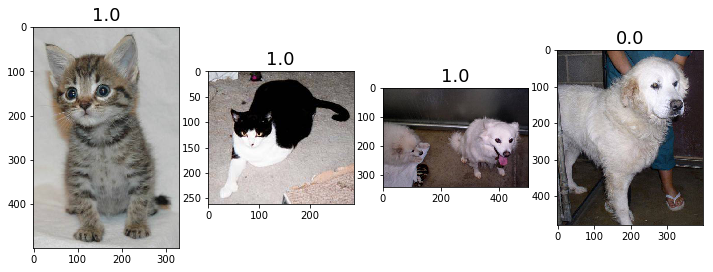

In [32]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

## Generate Predictions

In [ ]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)
# Error allocating 3347316736 bytes of device memory (out of memory).
# got this error when batch-size = 128
# I see this pop up to 6GB memory with batch_size = 64 & this takes some time...

In [ ]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

In [ ]:
#You can verify the column ordering by viewing some images
Image.open(test_path + filenames[1])

In [ ]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Submit Predictions to Kaggle!

In [ ]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [ ]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

In [ ]:
#play it safe, round down our edge predictions
#isdog = isdog.clip(min=0.05, max=0.95)
#isdog = isdog.clip(min=0.02, max=0.98)
isdog = isdog.clip(min=0.01, max=0.99)

In [ ]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [ ]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

In [ ]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission5.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [ ]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/'+submission_file_name)